In [140]:
# importing libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [141]:
# reading the dataset
df = pd.read_csv('Database.csv')
df.head()

,Unnamed: 0,Time,Season,Day_of_the_week,DHI,DNI,GHI,Wind_speed,Humidity,Temperature,PV_production,Wind_production,Electric_demand
0,0,2019-01-01-T00:00,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2810,22216
1,1,2019-01-01-T00:05,1,1,0.0,0.0,0.0,2.88,56.036,1.82,0,2862,22106
2,2,2019-01-01-T00:10,1,1,0.0,0.0,0.0,2.88,56.194,1.78,0,2916,22130
3,3,2019-01-01-T00:15,1,1,0.0,0.0,0.0,2.88,56.344,1.74,0,2920,22040
4,4,2019-01-01-T00:20,1,1,0.0,0.0,0.0,2.84,56.440,1.72,0,2902,21963


# Preprocessing

In [142]:
# droping redundant index column
df = df.drop(columns = ['Unnamed: 0'])

# checking the datatypes of the columns
print(df.info())

# converting the datatype of time column to datatime
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index("Time")
# extracting attributes from Time attribute
df['Month'] = df.index.month
df['Year'] = df.index.year
df['Date'] = df.index.date

# Combining the energy generated by both sources
df['Energy_produced'] = df['PV_production'] + df['Wind_production']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315648 entries, 0 to 315647
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             315648 non-null  object 
 1   Season           315648 non-null  int64  
 2   Day_of_the_week  315648 non-null  int64  
 3   DHI              315648 non-null  float64
 4   DNI              315648 non-null  float64
 5   GHI              315648 non-null  float64
 6   Wind_speed       315648 non-null  float64
 7   Humidity         315648 non-null  float64
 8   Temperature      315648 non-null  float64
 9   PV_production    315648 non-null  int64  
 10  Wind_production  315648 non-null  int64  
 11  Electric_demand  315648 non-null  int64  
dtypes: float64(6), int64(5), object(1)
memory usage: 28.9+ MB
None


In [143]:
# check missing values
df.isna().sum()

Season             0
Day_of_the_week    0
DHI                0
DNI                0
GHI                0
Wind_speed         0
Humidity           0
Temperature        0
PV_production      0
Wind_production    0
Electric_demand    0
Month              0
Year               0
Date               0
Energy_produced    0
dtype: int64

# EDA

### Time series plots

In [144]:
# time series plot
def time_series_plot(df, title, y_label, x_label):
    df.plot(title = title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()




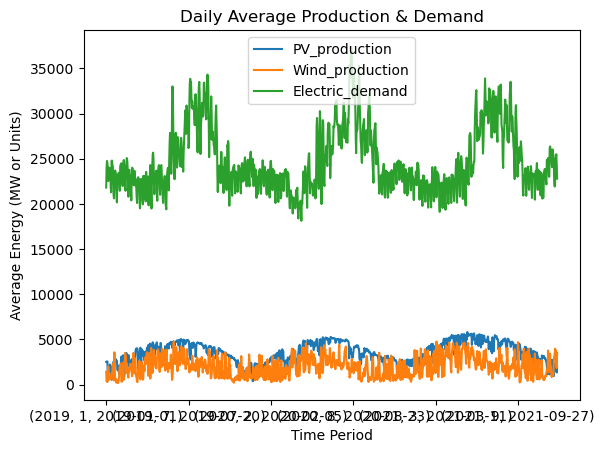

In [145]:
time_series_plot(
    df.groupby(by=['Year', 'Month', 'Date'])[['PV_production', 'Wind_production', 'Electric_demand']].mean(), 
    title="Daily Average Production & Demand", 
    y_label="Average Energy (MW or Units)", 
    x_label="Time Period"
)

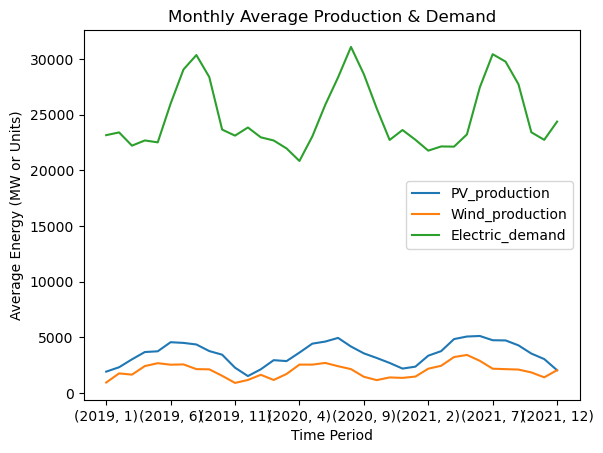

In [146]:
time_series_plot(
    df.groupby(by=['Year', 'Month'])[['PV_production', 'Wind_production', 'Electric_demand']].mean(), 
    title="Monthly Average Production & Demand", 
    y_label="Average Energy (MW or Units)", 
    x_label="Time Period"
)

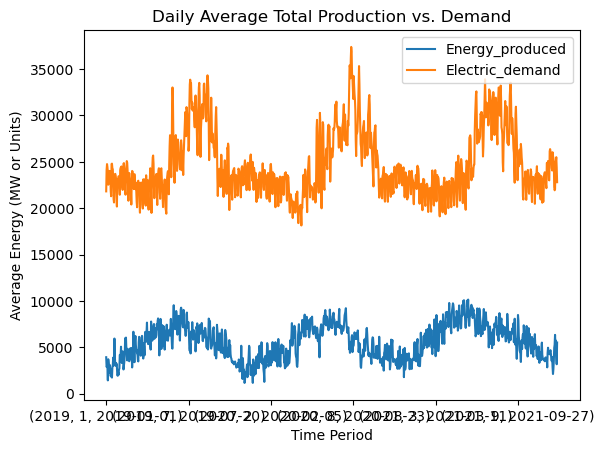

In [147]:
# analysing the gap between production and demand
time_series_plot(
    df.groupby(by=['Year', 'Month', 'Date'])[['Energy_produced', 'Electric_demand']].mean(), 
    title="Daily Average Total Production vs. Demand", 
    y_label="Average Energy (MW or Units)", 
    x_label="Time Period"
)

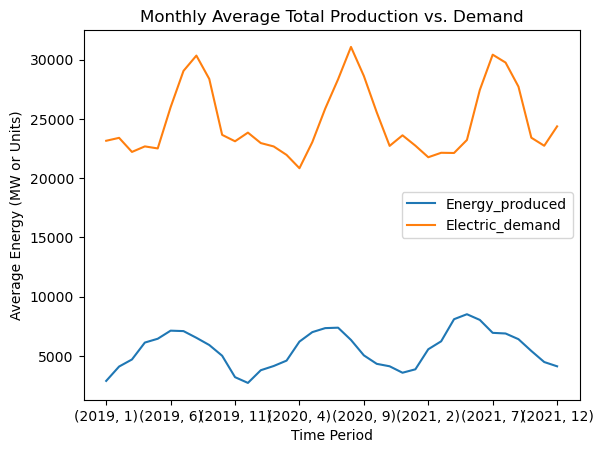

In [148]:
# analysing the gap between production and demand
time_series_plot(
    df.groupby(by=['Year', 'Month'])[['Energy_produced', 'Electric_demand']].mean(), 
    title="Monthly Average Total Production vs. Demand", 
    y_label="Average Energy (MW or Units)", 
    x_label="Time Period"
)

### Correlation analysis

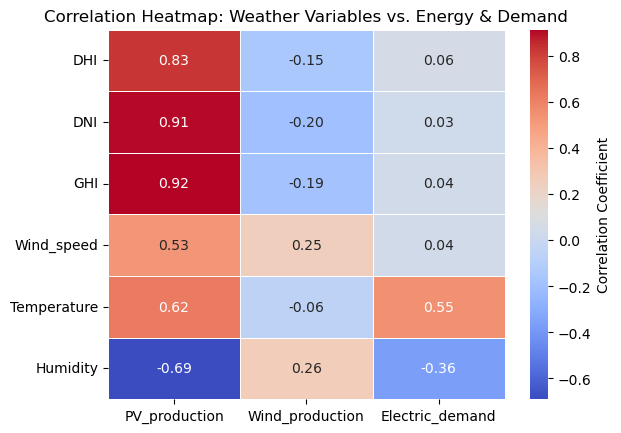

In [149]:
# Defining the variables for correlation analysis
weather_vars = ['DHI', 'DNI', 'GHI', 'Wind_speed', 'Temperature', 'Humidity']
production_vars = ['PV_production', 'Wind_production', 'Electric_demand']
corr_df = df[weather_vars + production_vars]
correlation_matrix = corr_df.corr()
relevant_corr = correlation_matrix.loc[weather_vars, production_vars]
sns.heatmap(relevant_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap: Weather Variables vs. Energy & Demand')
plt.show()

### Seasonal Decomposition

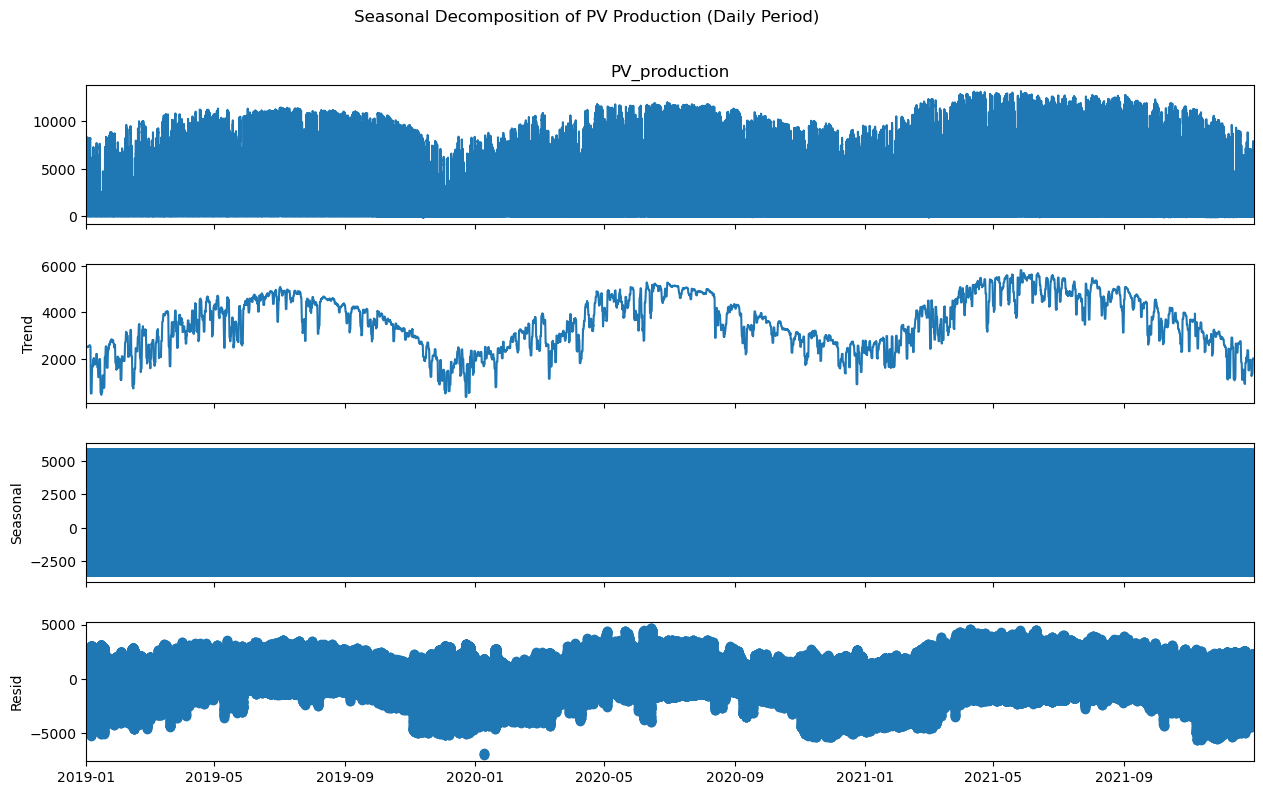

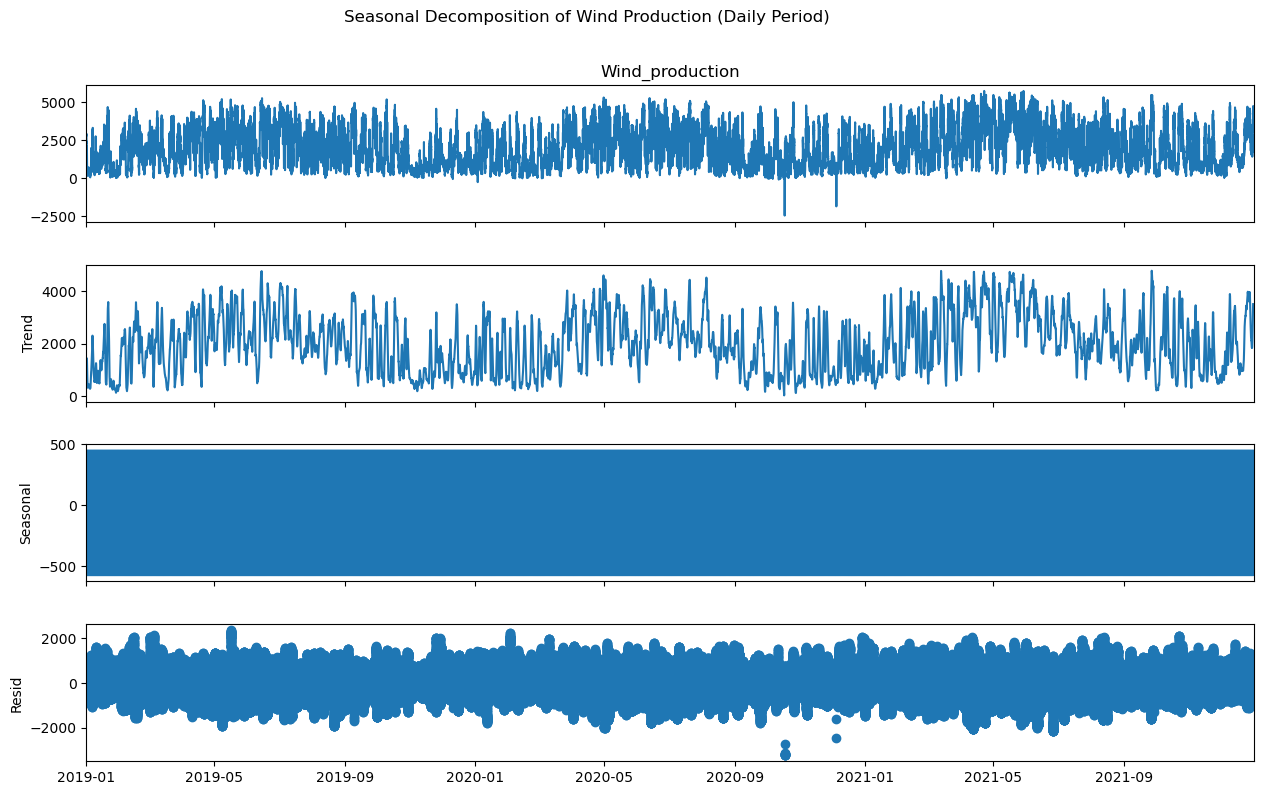

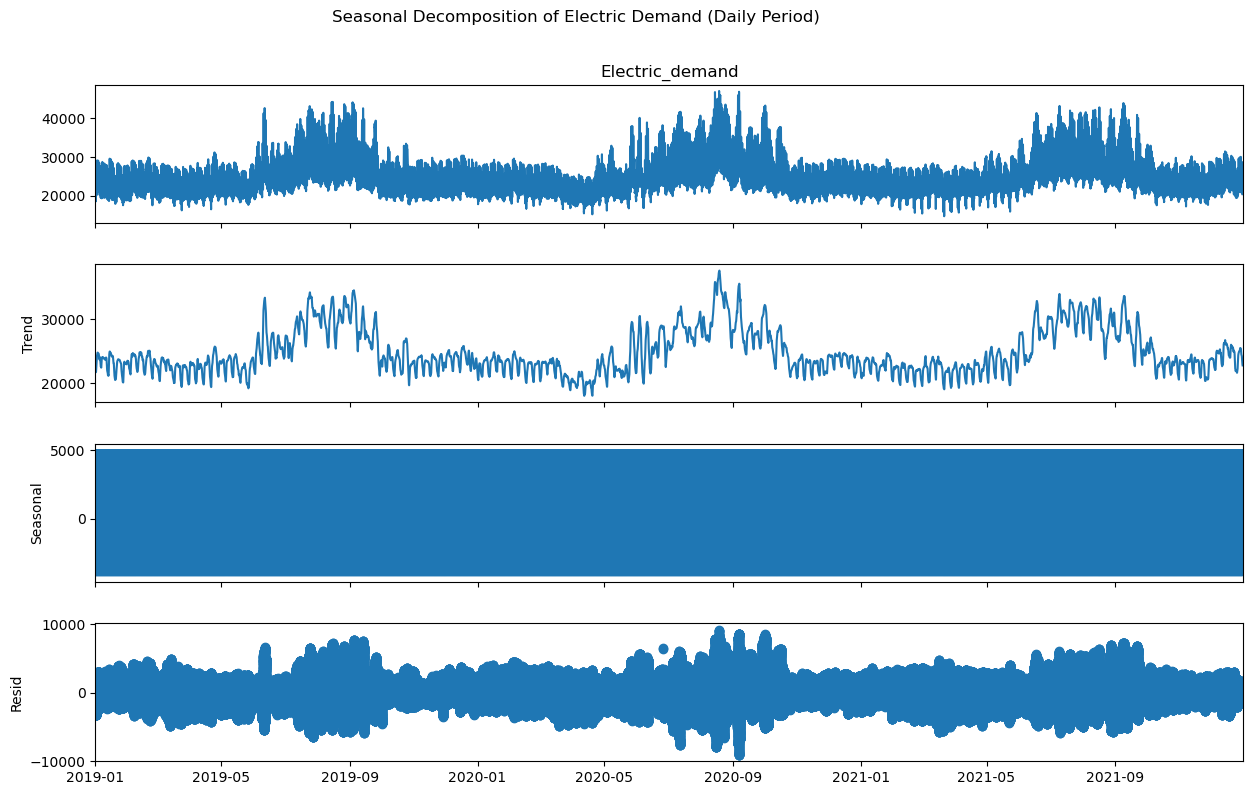

In [150]:
DAILY_PERIOD = 24 * 12

res_pv = seasonal_decompose(df['PV_production'], model='additive', period=DAILY_PERIOD)
fig = res_pv.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of PV Production (Daily Period)', y=1.02)
plt.show()

res_wind = seasonal_decompose(df['Wind_production'], model='additive', period=DAILY_PERIOD)
fig = res_wind.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of Wind Production (Daily Period)', y=1.02)
plt.show()

# Decompose Electric Demand (often has complex seasonality)
res_demand = seasonal_decompose(df['Electric_demand'], model='additive', period=DAILY_PERIOD)
fig_demand = res_demand.plot()
fig_demand.set_size_inches(14, 8)
fig_demand.suptitle('Seasonal Decomposition of Electric Demand (Daily Period)', y=1.02)
plt.show()

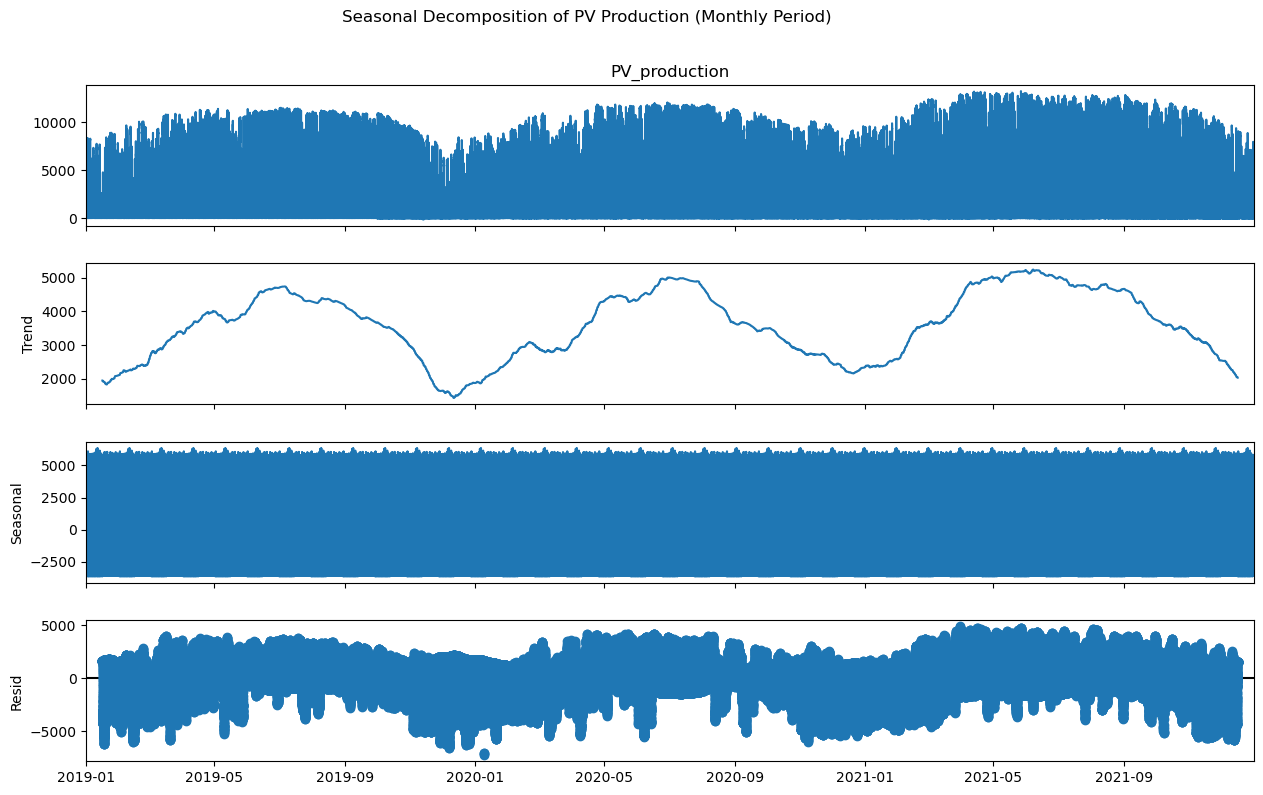

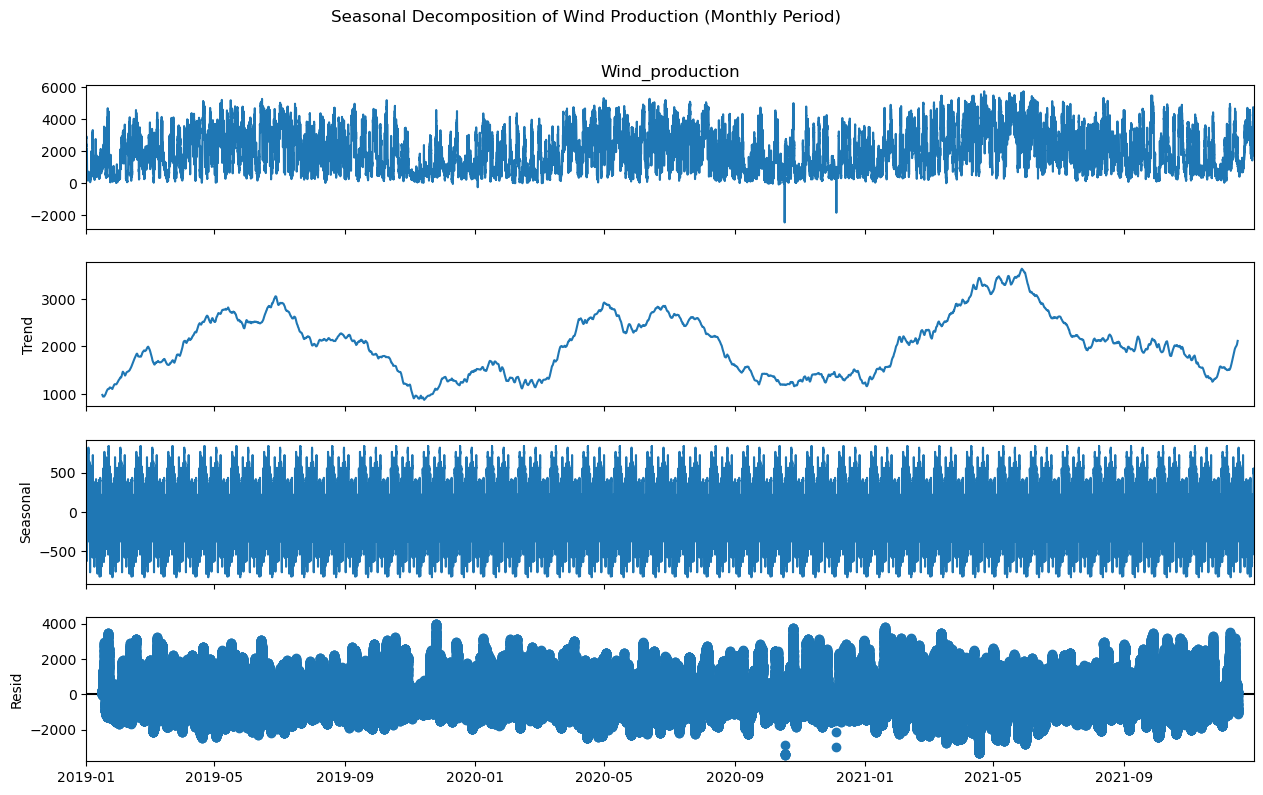

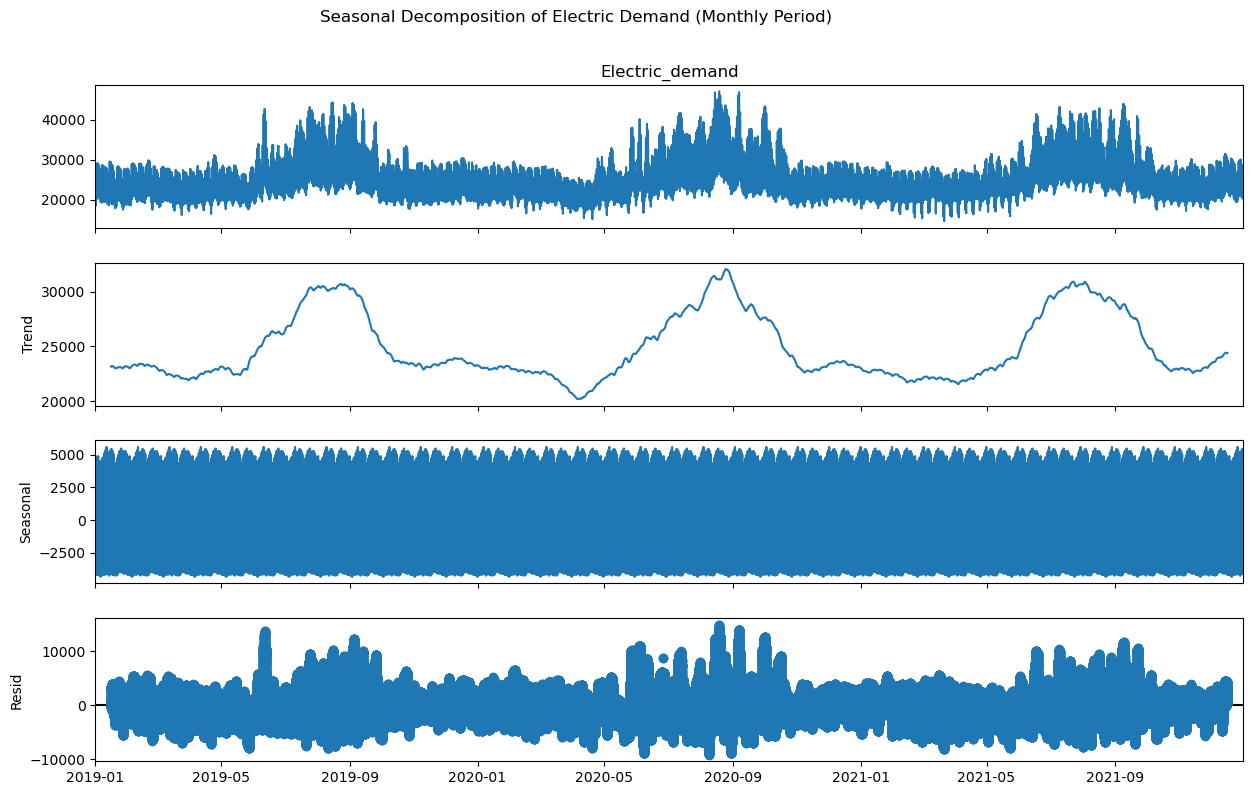

In [151]:
MONTHLY_PERIOD = 24 * 12 * 30

res_pv = seasonal_decompose(df['PV_production'], model='additive', period=MONTHLY_PERIOD)
fig = res_pv.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of PV Production (Monthly Period)', y=1.02)
plt.show()

res_wind = seasonal_decompose(df['Wind_production'], model='additive', period=MONTHLY_PERIOD)
fig = res_wind.plot()
fig.set_size_inches(14, 8)
fig.suptitle('Seasonal Decomposition of Wind Production (Monthly Period)', y=1.02)
plt.show()

# Decompose Electric Demand (often has complex seasonality)
res_demand = seasonal_decompose(df['Electric_demand'], model='additive', period=MONTHLY_PERIOD)
fig_demand = res_demand.plot()
fig_demand.set_size_inches(14, 8)
fig_demand.suptitle('Seasonal Decomposition of Electric Demand (Monthly Period)', y=1.02)
plt.show()

### checking for stationarity in the data

In [152]:
def adf_test(series, name='Time Series', regression = 'ct'):
    """
    Perform the Augmented Dickey-Fuller test.
    Null Hypothesis (H0): The series is non-stationary (has a unit root).
    Alternative Hypothesis (HA): The series is stationary.
    """
    print(f"--- Augmented Dickey-Fuller Test for {name} ---")
    result = adfuller(series, autolag='AIC', regression=regression)
    df_output = pd.Series(
        result[0:4],
        index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used']
    )
    for key, value in result[4].items():
        df_output[f'Critical Value ({key})'] = value

    print(df_output)
    
    # Interpretation
    if result[1] <= 0.05:
        print(f"Conclusion: Reject H0. The {name} series is **Stationary** (p-value <= 0.05).")
    else:
        print(f"Conclusion: Fail to Reject H0. The {name} series is **Non-Stationary** (p-value > 0.05).")
    print("-" * 50)

In [153]:
adf_test(df.groupby(['Year', 'Month', 'Date'])['PV_production'].mean(), 'PV Production')

--- Augmented Dickey-Fuller Test for PV Production ---
Test Statistic                   -1.928875
p-value                           0.639578
Lags Used                        12.000000
Number of Observations Used    1083.000000
Critical Value (1%)              -3.967154
Critical Value (5%)              -3.414552
Critical Value (10%)             -3.129441
dtype: float64
Conclusion: Fail to Reject H0. The PV Production series is **Non-Stationary** (p-value > 0.05).
--------------------------------------------------


In [154]:
adf_test(df.groupby(['Year', 'Month'])['PV_production'].mean(), 'PV Production')

--- Augmented Dickey-Fuller Test for PV Production ---
Test Statistic                 -3.996219
p-value                         0.008903
Lags Used                       7.000000
Number of Observations Used    28.000000
Critical Value (1%)            -4.324466
Critical Value (5%)            -3.580882
Critical Value (10%)           -3.225419
dtype: float64
Conclusion: Reject H0. The PV Production series is **Stationary** (p-value <= 0.05).
--------------------------------------------------


In [155]:
adf_test(df.groupby(['Year', 'Month', 'Date'])['Wind_production'].mean(), 'Wind Production')

--- Augmented Dickey-Fuller Test for Wind Production ---
Test Statistic                   -3.150241
p-value                           0.094780
Lags Used                        18.000000
Number of Observations Used    1077.000000
Critical Value (1%)              -3.967200
Critical Value (5%)              -3.414574
Critical Value (10%)             -3.129454
dtype: float64
Conclusion: Fail to Reject H0. The Wind Production series is **Non-Stationary** (p-value > 0.05).
--------------------------------------------------


In [156]:
adf_test(df.groupby(['Year', 'Month'])['Wind_production'].mean(), 'Wind Production')


--- Augmented Dickey-Fuller Test for Wind Production ---
Test Statistic                 -0.440563
p-value                         0.985591
Lags Used                      10.000000
Number of Observations Used    25.000000
Critical Value (1%)            -4.374965
Critical Value (5%)            -3.603468
Critical Value (10%)           -3.238186
dtype: float64
Conclusion: Fail to Reject H0. The Wind Production series is **Non-Stationary** (p-value > 0.05).
--------------------------------------------------


In [157]:
adf_test(df.groupby(['Year', 'Month', 'Date'])['Electric_demand'].mean(), 'Electricty demand')


--- Augmented Dickey-Fuller Test for Electricty demand ---
Test Statistic                   -2.531432
p-value                           0.312430
Lags Used                        22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.967232
Critical Value (5%)              -3.414590
Critical Value (10%)             -3.129463
dtype: float64
Conclusion: Fail to Reject H0. The Electricty demand series is **Non-Stationary** (p-value > 0.05).
--------------------------------------------------


In [158]:
adf_test(df.groupby(['Year', 'Month'])['Electric_demand'].mean(), 'Electricty demand')

--- Augmented Dickey-Fuller Test for Electricty demand ---
Test Statistic                 -4.215742
p-value                         0.004238
Lags Used                       9.000000
Number of Observations Used    26.000000
Critical Value (1%)            -4.356652
Critical Value (5%)            -3.595300
Critical Value (10%)           -3.233576
dtype: float64
Conclusion: Reject H0. The Electricty demand series is **Stationary** (p-value <= 0.05).
--------------------------------------------------


In [159]:
def plot_acf_pacf(series, name, lags=40):
    """
    Generates and displays Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

    These plots are essential for identifying non-stationarity and determining the p, q, P, Q orders for ARIMA/SARIMA models.

    Args:
        series (pd.Series): The time series data.
        name (str): The name of the series for plot titles.
        lags (int): The number of lags to display.
    """
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # Remove NaN values before plotting
    # series_clean = series.dropna()
    # print(series_clean)

    plot_acf(series, lags=lags, ax=axes[0], title=f'ACF for {name}')
    plot_pacf(series, lags=lags, ax=axes[1], title=f'PACF for {name}', method='ywm')

    # Add a horizontal line at y=0 for clarity
    axes[0].axhline(0, linestyle='--', color='gray')
    axes[1].axhline(0, linestyle='--', color='gray')
    
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_49377/3612856534.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df[series].resample('M').mean().dropna()


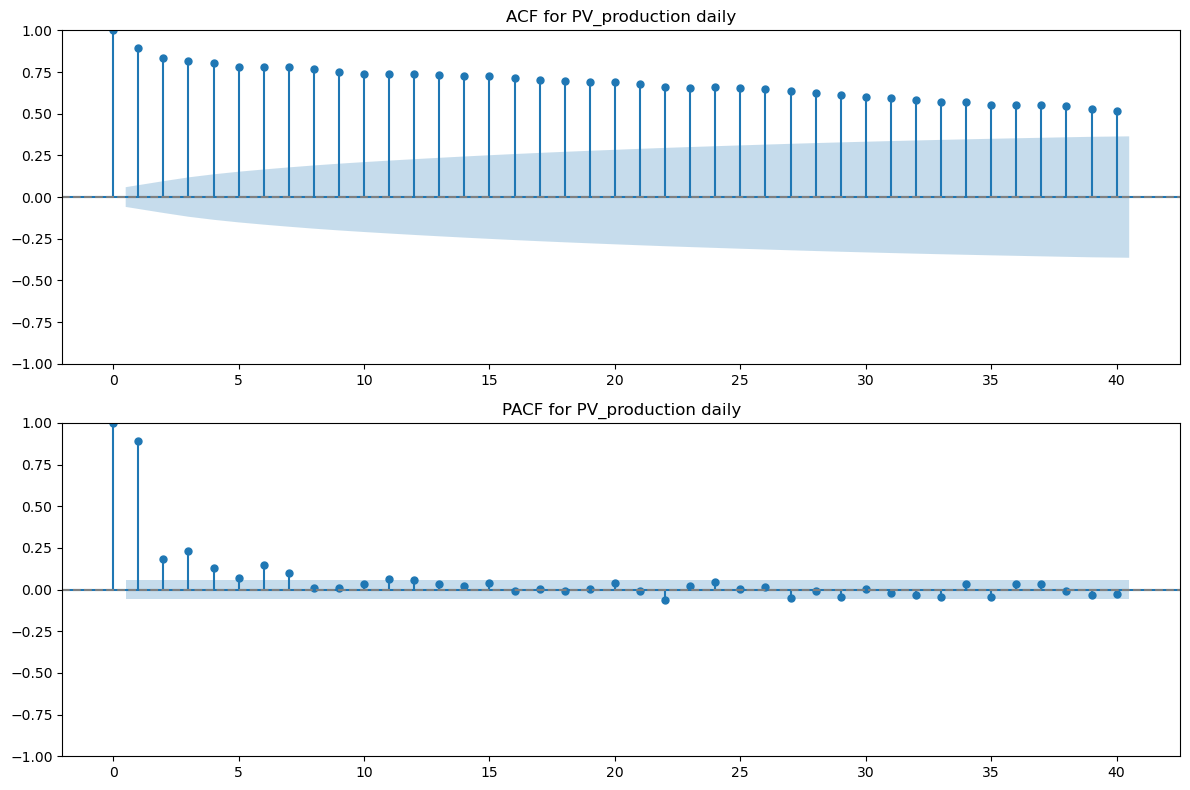

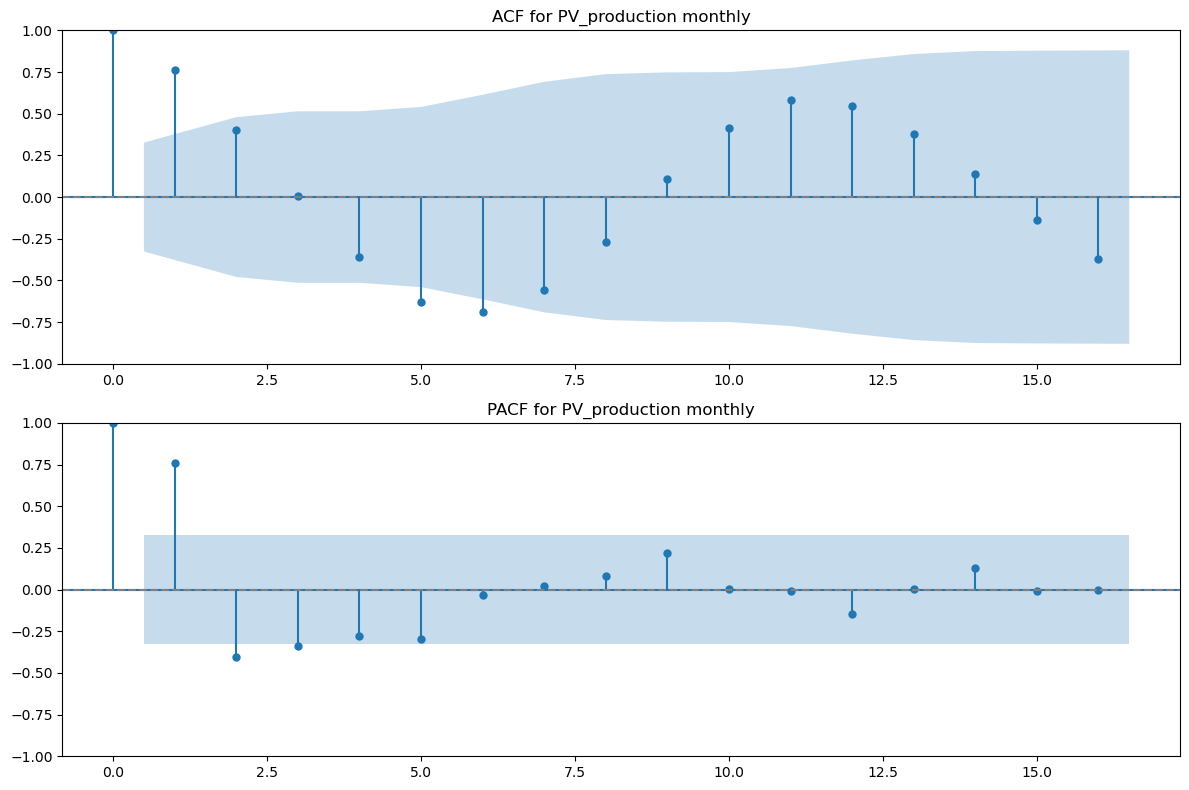

/tmp/ipykernel_49377/3612856534.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df[series].resample('M').mean().dropna()


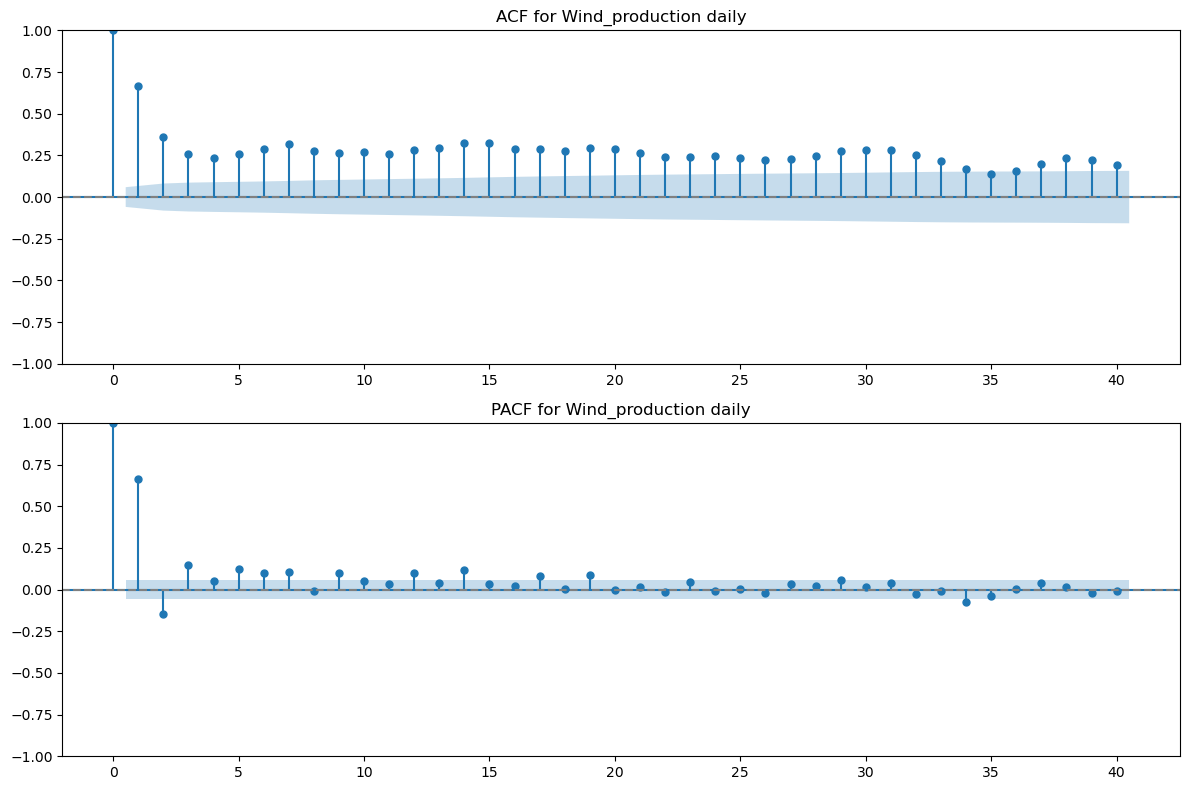

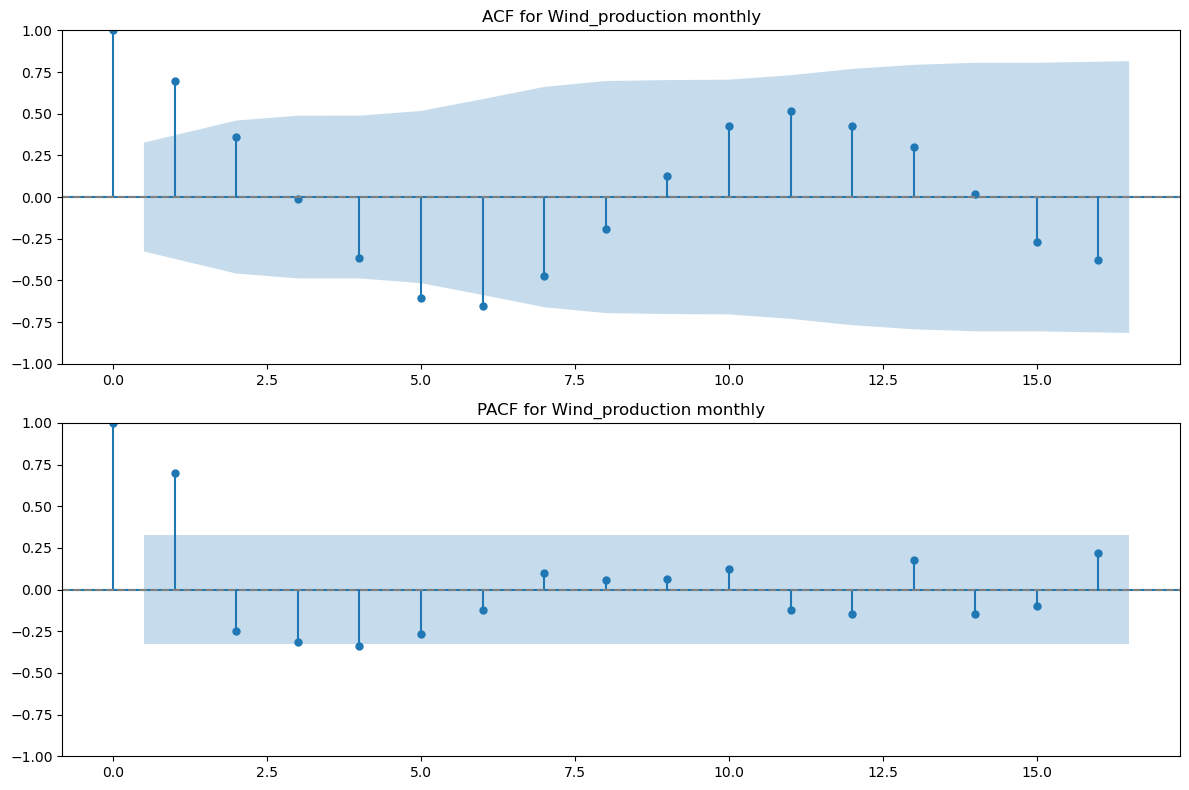

/tmp/ipykernel_49377/3612856534.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df2 = df[series].resample('M').mean().dropna()


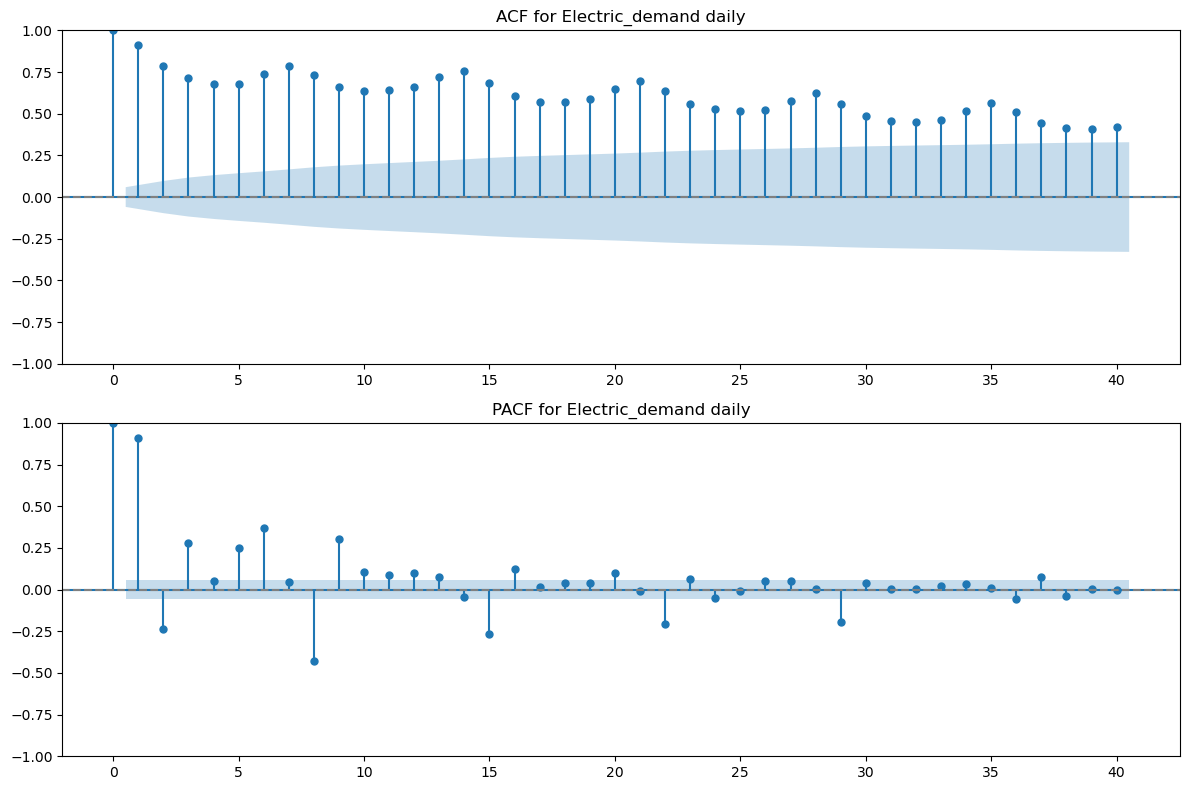

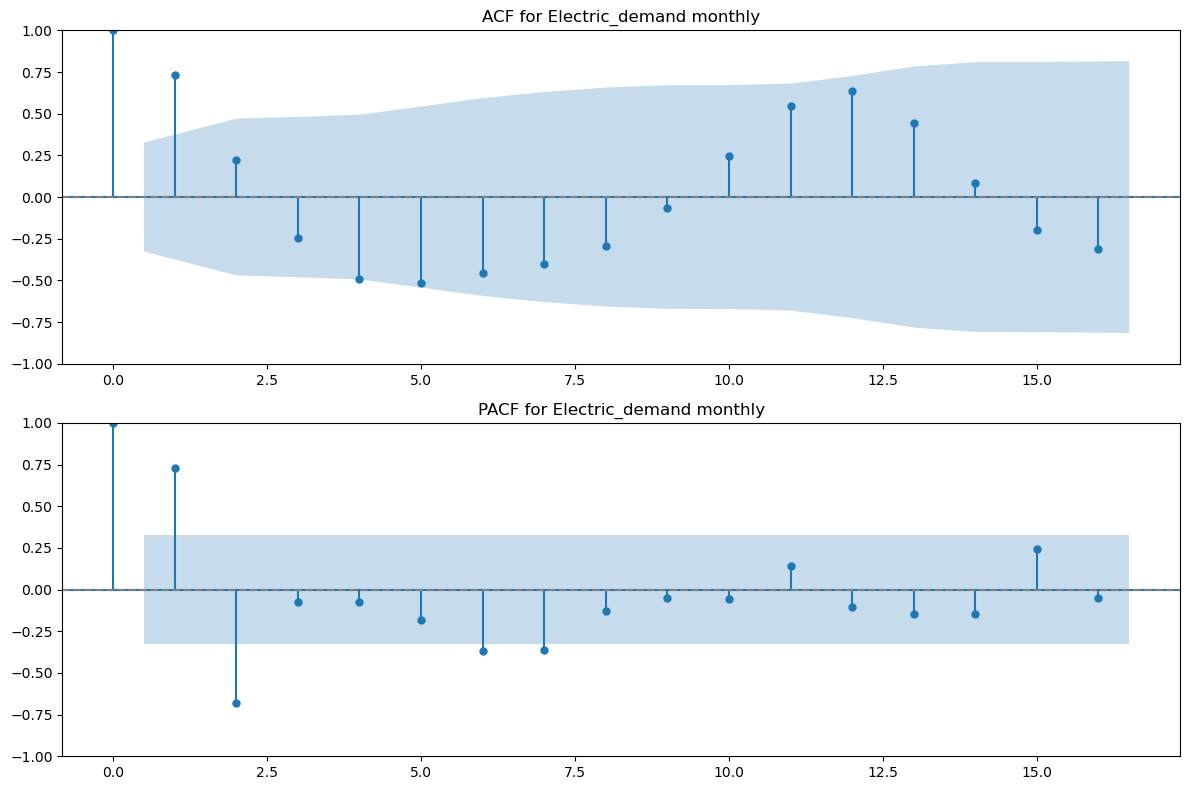

In [160]:
series_list = ['PV_production', 'Wind_production', 'Electric_demand']
lags = 40
for series in series_list:
    df1 = df[series].resample('D').mean().dropna()
    df2 = df[series].resample('M').mean().dropna()

    plot_acf_pacf(df1, f'{series} daily', lags= min(lags, df1.shape[0] - 2))
    plot_acf_pacf(df2, f'{series} monthly', lags = min(lags, df2.shape[0]//2 - 2))
